In [1]:
from utils import *
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import rdkit

In [ ]:
run_crest_pipeline("cation_smiles.txt", 128)

In [ ]:
conf_dict_with = {}
desc_dict_with = {}
conf_dict_without = {}
desc_dict_without = {}
total_with, total_without = 0, 0
for i in list(range(58)):
    print(f"----- Salt #{i} -----")
    with_ce, without_ce, best_ce = make_best_ensemble(i)
    
    n_atoms = with_ce.elements.shape[0]
    if with_ce.n_conformers > 100 or without_ce.n_conformers > 100:
        rmsd_thresh = 1.0
        energy_thresh = 1.5
    else:
        rmsd_thresh = 0.5
        energy_thresh = 3.0
    with_ce = trim_conformers(with_ce, rmsd_thresh=rmsd_thresh, energy_thresh=energy_thresh)
    conf_dict_with[i] = (with_ce, with_ce.n_conformers)
    total_with += with_ce.n_conformers
    without_ce = trim_conformers(without_ce, rmsd_thresh=rmsd_thresh, energy_thresh=energy_thresh)
    conf_dict_without[i] = (without_ce, without_ce.n_conformers)
    total_without += without_ce.n_conformers
    print(f"   Atoms: {n_atoms}, rmsd: {rmsd_thresh}, energy: {energy_thresh}, with: {with_ce.n_conformers}, without: {without_ce.n_conformers}")
    dump_conformers(with_ce, i, withh=True)
    dump_conformers(without_ce, i, withh=False)
    gen_hess(i, 64, withh=True)
    gen_hess(i, 64, withh=False)
    with_bw = with_ce.boltzmann_weights().T
    without_bw = without_ce.boltzmann_weights().T
    with_ensemble_desc = get_ensemble_descriptors(i, withh=True, dispersion=True, SASA=True, XTB=True, LFCs="N_H")
    without_ensemble_desc = get_ensemble_descriptors(i, withh=False, dispersion=True, SASA=True, XTB=True, LFCs="N_H")
    n_conformers, n_descriptors = len(list(with_ensemble_desc)), len(list(with_ensemble_desc[0].values()))
    bw_desc_with = boltz_weight_desc(with_ensemble_desc, with_bw)
    bw_desc_without = boltz_weight_desc(without_ensemble_desc, without_bw) 
    desc_dict_with[i] = bw_desc_with
    desc_dict_without[i] = bw_desc_without
def make_dfs(withh, without):
    return pd.DataFrame.from_dict(withh, orient="index"), pd.DataFrame.from_dict(without, orient="index")
with_df, without_df = make_dfs(desc_dict_with, desc_dict_without)
with_df.to_csv("descriptors_with_chlorine.csv", index=False)
without_df.to_csv("descriptors_without_chlorine.csv", index=False)

In [2]:
def features():
    # Some third dimensions
    mol_wt = {}
    aromatic = {}
    bonds = {}
    sulfur = {}
    for salt in sorted(os.listdir("./")):
        if "salt_" in salt:
            n = str(salt.split("_")[1])
            SMILES = open(f"salt_{n}/with_chlorine/smiles.txt", "r").readlines()[0].replace("\n", "").split()[0]
            SMILES = SMILES.replace("[NH3]", "N").replace("[Cl]", "Cl")

            mol = Chem.MolFromSmiles(SMILES, sanitize=True)
            mol_wt[int(n)] = {"mol_wt": round(rdkit.Chem.Descriptors.MolWt(mol), 3)}
            arom = 0
            for atom in mol.GetAtoms():
                arom += atom.GetIsAromatic()
            dbonds = 0
            for bond in mol.GetBonds():
                btype = bond.GetBondType()
                if btype.name in ["DOUBLE", "AROMATIC", "TRIPLE"]:
                    dbonds += 1

            aromatic[int(n)] = {"aromatic": arom}
            bonds[int(n)] = {"n_double_bonds": dbonds}
            sulfur[int(n)] = {"sulfur": mol.HasSubstructMatch(Chem.MolFromSmiles('S'))}

    mol_wt = pd.DataFrame.from_dict(mol_wt, orient="index")
    aromatic = pd.DataFrame.from_dict(aromatic, orient="index")
    bonds = pd.DataFrame.from_dict(bonds, orient="index")
    sulfur = pd.DataFrame.from_dict(sulfur, orient="index")
    
    return mol_wt, aromatic, bonds, sulfur

In [3]:
mol_wt, aromatic, bonds, sulfur = features()

In [4]:
# generate single figure with certain size
def gen_single_figure(size=(20, 9)):

    fig, ax = plt.subplots(figsize=size)
    ax.grid(True, linewidth=1.0, color='0.95')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_axisbelow(True)
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
        tick.set_fontsize(12)
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")
        tick.set_fontsize(12)
    
    return fig, ax

['disp_area', 'disp_volume', 'disp_p_int', 'disp_p_max', 'disp_p_min', 'sasa_area', 'sasa_volume', 'ip', 'ea', 'LFCs_N_H_0', 'LFqCs_N_H_0', 'LFCs_N_H_1', 'LFqCs_N_H_1', 'LFCs_N_H_2', 'LFqCs_N_H_2']


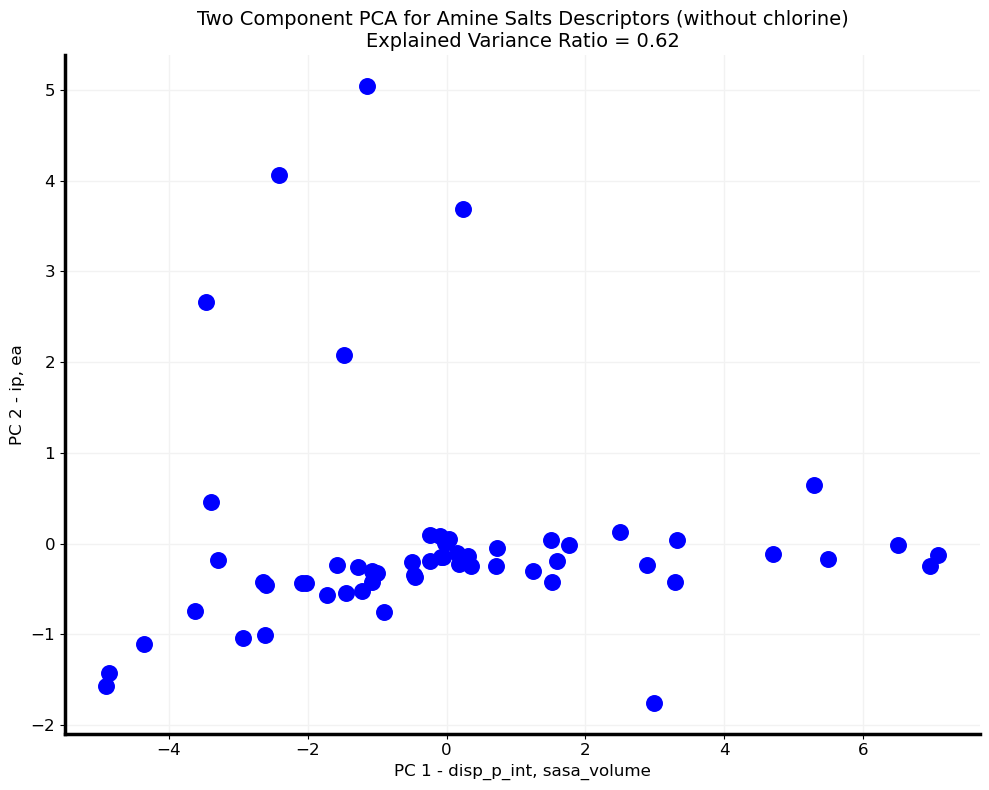

In [11]:
# define pandas DataFrame with Descriptor representation salts
df = pd.read_csv("descriptors_without_chlorine.csv")
columns = list(df.columns)
print(columns)
# use a StandardScaler to transform the Descriptors for PCA
df = StandardScaler().fit_transform(df)
# fit PCA
pca = PCA(n_components=2)
pcas = pca.fit_transform(df)
pca_df = pd.DataFrame(pcas, columns = ["PC 1", "PC 2"])
exp_var_ratio = pca.explained_variance_ratio_
# generate figure
fd_medium = {"name": "Arial", "size": 12}
fd_large = {"name": "Arial", "size": 14}
fig, ax = gen_single_figure(size = (10, 8))
# get top two features for each PC
pc_1_ifs = [columns[i] for i in (-pca.components_).argsort()[0][:2]]
pc_2_ifs = [columns[i] for i in (-pca.components_).argsort()[1][:2]]
# plot pcs
#plt.scatter(pca_df["PC 1"], pca_df["PC 2"], c = mol_wt.values.flatten().tolist(), cmap="copper", s = 125)
plt.scatter(pca_df["PC 1"], pca_df["PC 2"], c = "blue", s = 125)
#plt.colorbar(label="number of aromatic atoms", orientation="vertical", extend="both")
plt.title(f"Two Component PCA for Amine Salts Descriptors (without chlorine)\nExplained Variance Ratio = {round(np.sum(exp_var_ratio), 2)}", fontdict=fd_large)
plt.xlabel(f"PC 1 - {', '.join(pc_1_ifs)}", fontdict=fd_medium)
plt.ylabel(f"PC 2 - {', '.join(pc_2_ifs)}", fontdict=fd_medium)

plt.tight_layout()
fig.savefig("PCA_without_chlorine.png")

In [ ]:
pc_1 = [columns[i] for i in (-pca.components_).argsort()[0]]
pc_2 = [columns[i] for i in (-pca.components_).argsort()[1]]


In [ ]:
print(pc_1)
print(pc_2)